In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import math

import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interact_manual
from ipywidgets import FloatSlider

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans

<IPython.core.display.Javascript object>

In [3]:
song_df = pd.read_csv("../data/spotify_song_features.csv", index_col=0)

<IPython.core.display.Javascript object>

In [45]:
sp_info = pd.read_csv("../data/sp_info_tagged.csv", index_col=0)

<IPython.core.display.Javascript object>

In [5]:
timbre_cov_df = pd.read_csv("../data/timbre_df.csv", index_col=0)

<IPython.core.display.Javascript object>

In [6]:
timbre_cov_df = timbre_cov_df.set_index("id")

<IPython.core.display.Javascript object>

In [7]:
song_df["fm_tag"] = None
timbre_cov_df["fm_tag"] = None

<IPython.core.display.Javascript object>

In [46]:
sp_info

,artist,title,sp_title,sp_song_id,sp_artist,sp_artist_id,uuid,fm_tag,sp_tag
0,Flash Giordani,Re-Up,NaN,NaN,NaN,NaN,f4621e54-d65e-425e-866e-12560a34a0d8,alternative rap,NaN
1,Flash Giordani,Arctic Bandit,Arctic Bandit,0QE1NjeCyrAbYVVNwJDqsa,Flash Giordani,72p4Ib8eIBOJvaPYebydrf,0e6516af-b4d0-49de-b011-19e1803b8167,alternative rap,NaN
2,Flash Giordani,She Gone 2.0,SHE GONE 2.0 ( PROD. SCOTT $AUCE),40cvs2pISPXxPdHizhD9aE,Flash Giordani,72p4Ib8eIBOJvaPYebydrf,4b16f18a-3466-42e2-b890-93c70c98150f,alternative rap,NaN
3,Flash Giordani,Remember,Still Remember,7F0yyjJczDZ67zXbRuACyt,Flash Giordani,72p4Ib8eIBOJvaPYebydrf,ce02634e-5f62-4359-a6a8-ded507a0fd32,alternative rap,NaN
4,Flash Giordani,Slippery Slope,NaN,NaN,NaN,NaN,bad595b9-9f18-409e-9659-769390e3d38d,alternative rap,NaN
...,...,...,...,...,...,...,...,...,...
9854,Auvie Sinclair,Tracers,Tracers,5Qrz2yiIek61N7AA3PuKlP,Auvie Sinclair,6ipXxf4hCYh1XJXPto9egc,bad915ca-0279-4571-b918-d1c66b26b6f5,conscious rap,NaN
9855,Auvie Sinclair,Buzzinng,Buzzinng,2uf0MuzPOat3nem2fOL71H,Auvie Sinclair,6ipXxf4hCYh1XJXPto9egc,f5111595-bcb9-4b8a-a468-749aa9304f93,conscious rap,NaN
9856,Auvie Sinclair,Golden! (feat. Chi Chi),NaN,NaN,NaN,NaN,ea3d6202-156e-436e-a6e4-fde25c0b0b78,conscious rap,NaN
9857,Auvie Sinclair,Shine,Shine,5jSU23HHpQHveXlOUu4tGc,Auvie Sinclair,6ipXxf4hCYh1XJXPto9egc,119aa87c-3c80-4bf8-afa4-23abbf937eec,conscious rap,NaN


<IPython.core.display.Javascript object>

In [47]:
for i in range(song_df.shape[0]):
    s_id = song_df.loc[i, "id"]
    fm_tag = sp_info[sp_info["sp_song_id"] == s_id]["fm_tag"].values[0]
    song_df.loc[i, "fm_tag"] = fm_tag
    if s_id in timbre_cov_df.index:
        timbre_cov_df.loc[s_id, "fm_tag"] = fm_tag

<IPython.core.display.Javascript object>

In [48]:
timbre_cov_df.loc[
    timbre_cov_df["fm_tag"].isin(["West coast rap", "hyphy"]), "fm_tag"
] = "west coast"
timbre_cov_df.loc[
    timbre_cov_df["fm_tag"].isin(["East coast rap", "boom bap"]), "fm_tag"
] = "east coast"
timbre_cov_df.loc[
    timbre_cov_df["fm_tag"].isin(["southern rap", "crunk"]), "fm_tag"
] = "southern"

<IPython.core.display.Javascript object>

In [49]:
tagged = timbre_cov_df[timbre_cov_df["fm_tag"].isna() == False]
X = tagged.drop("fm_tag", 1)
y = tagged["fm_tag"]
drop_cols = ["t2-t2", "t3-t3", "t5-t5", "t7-t7", "t9-t9", "t10-t10"]

X = X.drop(drop_cols, 1)

<IPython.core.display.Javascript object>

In [50]:
scaler = StandardScaler()
std_X = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

In [51]:
umap = UMAP(
    n_components=2, n_neighbors=40, min_dist=0.001, metric="cosine", random_state=42,
)
umap_df = pd.DataFrame(umap.fit_transform(std_X), columns=["c0", "c1"])


<IPython.core.display.Javascript object>

In [52]:
umap_df["fm_tag"] = y.values

<IPython.core.display.Javascript object>

/home/b1t/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='c0', ylabel='c1'>

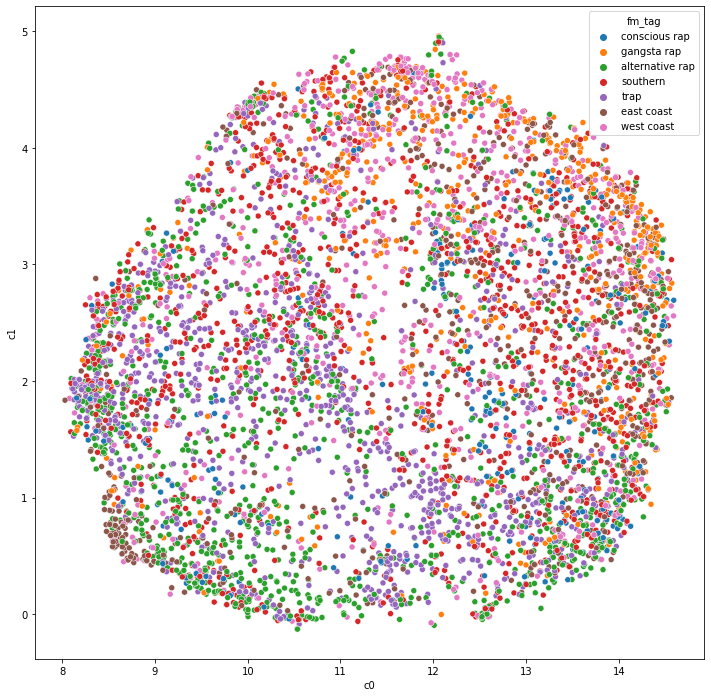

<IPython.core.display.Javascript object>

In [53]:
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", data=umap_df, hue="fm_tag")

In [54]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

<IPython.core.display.Javascript object>

In [55]:
import fasttext

PRETRAINED_MODEL_PATH = '/tmp/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)


<IPython.core.display.Javascript object>

In [56]:
lyrics_df = pd.read_csv("../data/lyrics.csv", index_col="id")

<IPython.core.display.Javascript object>

In [57]:
lyrics_df.dropna()

,original,cleaned,lang
id,,,
1oK6IuZqBqljKHS3bFNUg7,Puff puff pass and I'm in that\nCircle with my...,puff puff pass circl boy roll weed zig zag lig...,en
1MSY5BfSg3wmtUFmtSBjs5,"Yo, what's happenin Cold 187\nYo man, you know...",yo happenin cold yo man know laid back studio ...,en
073YMUpCNOSQjh5Mdr3H4A,Normalerweise kommt man so nicht in Clubs\nIch...,normalerweis kommt man nicht club ich bin nich...,de
6k4PmS9TcDQiEapSZkkcWB,Parlo da solo stanotte che chi mi ascolterebbe...,parlo da solo stanott che chi mi ascolterebb d...,it
1AGjfwW4QoWFfhp1IA6wcE,"Yeah man, ever since I was a kid like\nPeople ...",yeah man ever sinc kid like peopl would ask fa...,en
...,...,...,...
1IXFUiox0g7GZMd0qfVrWF,"L.T., Uh, The nerve of this bitch\n\nA bitch m...",uh nerv bitch bitch main purpos servic mac ski...,en
5bDv490EvT3CR6mfF78xL5,In the kitchen whipping up the cocaina\nPull u...,kitchen whip cocaina pull chick vroom vroom se...,en
2ada2pkDF8JKXlrhJLxzV8,I haven't been sober in a week or more\nAnd my...,sober week card got declin liquor store spent ...,en


<IPython.core.display.Javascript object>

In [58]:
english_lyrics = lyrics_df[lyrics_df["lang"] == "en"].dropna()

<IPython.core.display.Javascript object>

In [59]:
tfidf = TfidfVectorizer(min_df=2)
vectorized = tfidf.fit_transform(english_lyrics["cleaned"])

<IPython.core.display.Javascript object>

In [60]:
tfidf_df = pd.DataFrame(
    vectorized.toarray(), columns=tfidf.get_feature_names(), index=english_lyrics.index
)

<IPython.core.display.Javascript object>

In [71]:
tfidf_df

,aa,aaaah,aaaahhh,aah,aahh,aaliyah,aam,aaron,ab,abacus,...,zoomin,zoot,zoovi,zoovier,zoowap,zora,zucchini,zuckerberg,zulu,ńemi
id,,,,,,,,,,,,,,,,,,,,,
1oK6IuZqBqljKHS3bFNUg7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1MSY5BfSg3wmtUFmtSBjs5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1AGjfwW4QoWFfhp1IA6wcE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0FRENAN5snwnoRVJ6eDuFm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3BUWNzPWz2mDbptZmGEXpB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06R3hA4D1jyj8f8untfQNB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1IXFUiox0g7GZMd0qfVrWF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5bDv490EvT3CR6mfF78xL5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [43]:
timbre_cov_df

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t10-t9,t11-t9,t0-t10,t1-t10,t10-t10,t0-t11,t1-t11,t10-t11,t11-t11,fm_tag
id,,,,,,,,,,,,,,,,,,,,,
1oK6IuZqBqljKHS3bFNUg7,51.823612,20.298719,-7.290977,-11.141729,27.893418,-17.370409,2.325935,-5.247523,7.916673,1.860364,...,-9.255381,12.455460,-3.977513,-48.312000,261.299412,-7.627733,-75.358357,-16.209842,174.110043,conscious rap
1MSY5BfSg3wmtUFmtSBjs5,42.902985,57.353380,-8.897260,0.845510,34.859784,-18.322556,-10.257845,2.666678,-3.077387,6.007564,...,-35.039057,0.690710,2.864370,78.139559,289.719916,-5.924260,57.640365,-25.937092,187.967932,gangsta rap
073YMUpCNOSQjh5Mdr3H4A,51.320322,21.978182,21.876141,9.708738,21.285144,-13.235833,10.511639,8.868929,-14.419142,1.017309,...,-12.405163,9.488410,-3.525158,-31.851975,246.398071,-9.402846,15.085525,-17.672299,179.191567,conscious rap
6k4PmS9TcDQiEapSZkkcWB,47.247010,11.126041,-23.075194,-13.589925,44.776245,-16.985980,-12.936440,-10.717618,-11.349298,0.989104,...,-38.364132,46.119521,1.786425,-93.227843,321.643500,-2.372743,22.555682,-29.756121,222.617446,conscious rap
1AGjfwW4QoWFfhp1IA6wcE,47.404934,34.067367,-8.539390,-11.257607,37.728593,-14.631699,-4.338456,0.631410,-6.794711,7.955006,...,-51.221066,23.881200,-3.873569,-64.942901,279.560282,-13.661741,-123.210046,-37.850406,226.895772,conscious rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1IXFUiox0g7GZMd0qfVrWF,48.167950,136.626270,-60.834595,-18.636593,23.453316,-20.007310,-30.888675,12.623248,-1.928215,14.970483,...,-107.129587,43.907455,-2.716237,30.357385,387.114350,2.861127,325.858544,-64.247224,353.512932,gangsta rap
5bDv490EvT3CR6mfF78xL5,44.763783,76.052035,-23.341510,-11.778465,19.383785,-5.344268,8.010707,9.105040,-20.509906,12.718325,...,-49.886646,51.005932,5.100442,81.684350,607.092075,-17.092134,-12.106612,-92.024391,256.953795,trap
2ada2pkDF8JKXlrhJLxzV8,51.636761,49.987225,-8.736434,-18.482447,24.550814,-34.695512,-0.372974,6.119248,-2.831585,2.180300,...,-10.770460,10.104666,4.061721,-45.077901,209.518938,-3.142690,57.088009,-5.135911,190.890822,NaN


<IPython.core.display.Javascript object>

In [72]:
english_timbre = timbre_cov_df.loc[tfidf_df.index]

<IPython.core.display.Javascript object>

In [76]:
english_timbre = english_timbre.dropna()

<IPython.core.display.Javascript object>

In [77]:
english_df = english_timbre.join(tfidf_df, how="inner")

<IPython.core.display.Javascript object>

In [78]:
english_df

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,zoomin,zoot,zoovi,zoovier,zoowap,zora,zucchini,zuckerberg,zulu,ńemi
id,,,,,,,,,,,,,,,,,,,,,
1oK6IuZqBqljKHS3bFNUg7,51.823612,20.298719,-7.290977,-11.141729,27.893418,-17.370409,2.325935,-5.247523,7.916673,1.860364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1MSY5BfSg3wmtUFmtSBjs5,42.902985,57.353380,-8.897260,0.845510,34.859784,-18.322556,-10.257845,2.666678,-3.077387,6.007564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1AGjfwW4QoWFfhp1IA6wcE,47.404934,34.067367,-8.539390,-11.257607,37.728593,-14.631699,-4.338456,0.631410,-6.794711,7.955006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0FRENAN5snwnoRVJ6eDuFm,52.681160,29.980085,-1.945032,-13.859451,12.382230,-28.704957,2.412424,-2.794719,-8.170406,0.454160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3BUWNzPWz2mDbptZmGEXpB,48.484193,58.049115,-36.059879,-12.723216,23.898047,-9.801913,0.883274,-1.970918,-2.450077,3.441761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0AN7KIF9qkbzk2p2tG7jPE,51.095756,54.995009,18.079298,13.394617,16.707211,-8.645826,-6.329316,5.124032,0.545788,0.929071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4MrfYtNMl169SWUH8cJBli,49.905521,3.800089,4.192998,1.451093,22.359075,-19.951405,7.122938,-0.245278,-9.628937,-1.527966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06R3hA4D1jyj8f8untfQNB,50.046513,70.963756,-45.772269,-14.639832,17.559342,6.202878,-8.205195,-5.404654,-8.536383,6.549886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [79]:
tagged = timbre_cov_df.dropna()
# X = tagged.drop("fm_tag", 1)
X = english_df.drop("fm_tag", 1)
y = english_df["fm_tag"]
# drop_cols = ["t2-t2", "t3-t3", "t5-t5", "t7-t7", "t9-t9", "t10-t10"]

# X = X.drop(drop_cols, 1)

<IPython.core.display.Javascript object>

In [80]:
from sklearn.model_selection import train_test_split

<IPython.core.display.Javascript object>

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=34
)

<IPython.core.display.Javascript object>

In [82]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<IPython.core.display.Javascript object>

In [83]:
from sklearn.neighbors import KNeighborsClassifier

<IPython.core.display.Javascript object>

In [84]:
knn = KNeighborsClassifier(n_neighbors=20, n_jobs=-1, weights="distance")

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.24333333333333335

<IPython.core.display.Javascript object>

In [85]:
scaler = StandardScaler()
std_X = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

In [86]:
umap = UMAP(
    n_components=2, n_neighbors=40, min_dist=0.001, metric="cosine", random_state=42,
)
umap_df = pd.DataFrame(umap.fit_transform(std_X), columns=["c0", "c1"])


<IPython.core.display.Javascript object>

/home/b1t/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='c0', ylabel='c1'>

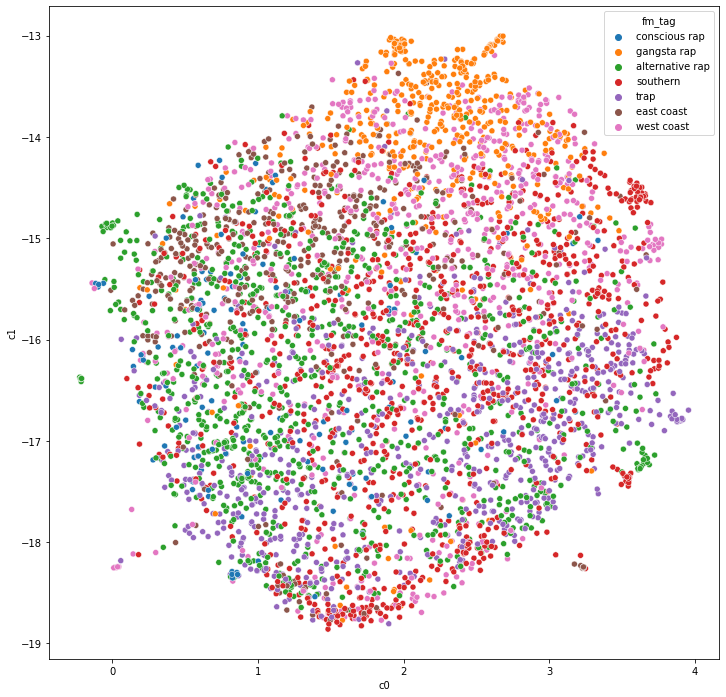

<IPython.core.display.Javascript object>

In [87]:
umap_df["fm_tag"] = y.values
plt.figure(figsize=(12, 12))
sns.scatterplot("c0", "c1", data=umap_df, hue="fm_tag")

In [88]:
english_df["fm_tag"].value_counts()

southern           986
alternative rap    917
west coast         778
trap               756
gangsta rap        469
east coast         451
conscious rap      143
Name: fm_tag, dtype: int64

<IPython.core.display.Javascript object>

In [89]:
english_df.to_csv("../data/english_tfidf_timbre.csv")

<IPython.core.display.Javascript object>

In [90]:
english_df

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,zoomin,zoot,zoovi,zoovier,zoowap,zora,zucchini,zuckerberg,zulu,ńemi
id,,,,,,,,,,,,,,,,,,,,,
1oK6IuZqBqljKHS3bFNUg7,51.823612,20.298719,-7.290977,-11.141729,27.893418,-17.370409,2.325935,-5.247523,7.916673,1.860364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1MSY5BfSg3wmtUFmtSBjs5,42.902985,57.353380,-8.897260,0.845510,34.859784,-18.322556,-10.257845,2.666678,-3.077387,6.007564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1AGjfwW4QoWFfhp1IA6wcE,47.404934,34.067367,-8.539390,-11.257607,37.728593,-14.631699,-4.338456,0.631410,-6.794711,7.955006,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0FRENAN5snwnoRVJ6eDuFm,52.681160,29.980085,-1.945032,-13.859451,12.382230,-28.704957,2.412424,-2.794719,-8.170406,0.454160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3BUWNzPWz2mDbptZmGEXpB,48.484193,58.049115,-36.059879,-12.723216,23.898047,-9.801913,0.883274,-1.970918,-2.450077,3.441761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0AN7KIF9qkbzk2p2tG7jPE,51.095756,54.995009,18.079298,13.394617,16.707211,-8.645826,-6.329316,5.124032,0.545788,0.929071,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4MrfYtNMl169SWUH8cJBli,49.905521,3.800089,4.192998,1.451093,22.359075,-19.951405,7.122938,-0.245278,-9.628937,-1.527966,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06R3hA4D1jyj8f8untfQNB,50.046513,70.963756,-45.772269,-14.639832,17.559342,6.202878,-8.205195,-5.404654,-8.536383,6.549886,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>

In [91]:
id_tags = english_df[["fm_tag"]]

<IPython.core.display.Javascript object>

In [93]:
id_tags.to_csv("../data/english_id_tags.csv")

<IPython.core.display.Javascript object>